# FA2024: CS663 - Data Mining - Team 9
## Unveiling Patterns in Airbnb NYC Listings: Dimensionality Reduction, Clustering, and Predictive Insights
+ Charani Sri Veerla - cveerla@uab.edu
+ Sai Poojith Reddy Gunukula - sgunukul@uab.edu
+ Shivathmika Gonti - sgonti@uab.edu
+ Sai Teja Appala - sappala@uab.edu
+ Vihari Damarla - vdamarla@uab.edu

# Required modules & libraries

In [1]:
# Import necessary libraries
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, confusion_matrix, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

# Exploring the dataset

In [2]:
# Part 1: Load and Preview Dataset
url = "extracted_airbnb_dataset/airbnb_dataset/AB_NYC_2019.csv"
df_original = pd.read_csv(url)
print("Initial Dataset Shape:", df_original.shape)
display(df_original.head())

Initial Dataset Shape: (48895, 21)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,9,10/19/2018,0.21,6,365,NaN,NaN,NaN,NaN,NaN
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,45,5/21/2019,0.38,2,355,NaN,NaN,NaN,NaN,NaN
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,0,NaN,NaN,1,365,NaN,NaN,NaN,NaN,NaN
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,270,7/5/2019,4.64,1,194,NaN,NaN,NaN,NaN,NaN
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,9,11/19/2018,0.10,1,0,NaN,NaN,NaN,NaN,NaN


# Data pre-processing, cleaning

In [3]:
# Part 2: Remove Unnecessary Columns
columns_to_keep = df_original.columns[:df_original.columns.get_loc('availability_365') + 1]
df_original = df_original[columns_to_keep]
print(f"Updated DataFrame Shape (after column filtering): {df_original.shape}")
display(df_original.head())

Updated DataFrame Shape (after column filtering): (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,10/19/2018,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,5/21/2019,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,7/5/2019,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,11/19/2018,0.10,1,0


In [4]:
# Part 3: Handle Missing Values
# Displaying missing values before handling
missing_values_before_handling = df_original.isnull().sum().reset_index()
missing_values_before_handling.columns = ['Column', 'Missing Values']
missing_values_before_handling['% Missing'] = (missing_values_before_handling['Missing Values'] / len(df_original)) * 100
print("Missing Values Before Handling:")
display(missing_values_before_handling)

# Replacing 'name' and 'host_name' with 'Unknown'
df_original['name'] = df_original['name'].fillna('Unknown')
df_original['host_name'] = df_original['host_name'].fillna('Unknown')

# Filling 'last_review' with the most frequent date per neighborhood group
df_original['last_review'] = df_original.groupby('neighbourhood_group')['last_review']\
    .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

# Replacing missing 'reviews_per_month' values with the group-wise mean
grouped_reviews_mean = df_original.groupby(['neighbourhood_group', 'room_type'])['reviews_per_month'].transform('mean')
df_original['reviews_per_month'] = df_original['reviews_per_month'].fillna(grouped_reviews_mean)

# Displaying missing values after handling
missing_values_after_handling = df_original.isnull().sum().reset_index()
missing_values_after_handling.columns = ['Column', 'Missing Values']
missing_values_after_handling['% Missing'] = (missing_values_after_handling['Missing Values'] / len(df_original)) * 100
print("Missing Values After Handling:")
display(missing_values_after_handling)

Missing Values Before Handling:


,Column,Missing Values,% Missing
0,id,0,0.000000
1,name,16,0.032723
2,host_id,0,0.000000
3,host_name,21,0.042949
4,neighbourhood_group,0,0.000000
5,neighbourhood,0,0.000000
6,latitude,0,0.000000
7,longitude,0,0.000000
8,room_type,0,0.000000
9,price,0,0.000000


Missing Values After Handling:


,Column,Missing Values,% Missing
0,id,0,0.0
1,name,0,0.0
2,host_id,0,0.0
3,host_name,0,0.0
4,neighbourhood_group,0,0.0
5,neighbourhood,0,0.0
6,latitude,0,0.0
7,longitude,0,0.0
8,room_type,0,0.0
9,price,0,0.0


# Feature Engineering & Normalization

In [5]:
# Feature Engineering
df_filtered = df_original.copy()
df_filtered['demand_score'] = df_filtered['reviews_per_month'] * df_filtered['number_of_reviews']

# Haversine Formula for Distance to a Landmark
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Add 'distance_to_landmark'
nyc_landmark = (40.7580, -73.9855)  # Times Square
df_filtered['distance_to_landmark'] = df_filtered.apply(
    lambda row: haversine(row['latitude'], row['longitude'], nyc_landmark[0], nyc_landmark[1]),
    axis=1
)

# Add 'booking_probability'
df_filtered['booking_probability'] = df_filtered['availability_365'] / (df_filtered['minimum_nights'] + 1)

# One-Hot Encode 'room_type'
if not any(col.startswith('room_type_') for col in df_filtered.columns):
    room_type_encoded = pd.get_dummies(df_filtered['room_type'], prefix='room_type')
    df_filtered = pd.concat([df_filtered, room_type_encoded], axis=1)

# Add 'host_dominance'
df_filtered['host_dominance'] = df_filtered['calculated_host_listings_count']

# Remove Duplicate Columns (if any)
df_filtered = df_filtered.loc[:, ~df_filtered.columns.duplicated()]

# Combine All Features for Normalization
features_to_normalize = [
    'price', 'availability_365', 'minimum_nights', 'number_of_reviews', 
    'latitude', 'longitude', 'demand_score', 'distance_to_landmark',
    'booking_probability', 'host_dominance'
] + [col for col in df_filtered.columns if col.startswith('room_type_')]

# Normalize Features
scaler = MinMaxScaler()
df_filtered[features_to_normalize] = scaler.fit_transform(df_filtered[features_to_normalize])

# Display normalized features
print("Normalized Features:")
display(df_filtered[features_to_normalize].head())

Normalized Features:


,price,availability_365,minimum_nights,number_of_reviews,latitude,longitude,demand_score,distance_to_landmark,booking_probability,host_dominance,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0.0149,1.000000,0.000000,0.014308,0.357393,0.511921,0.000206,0.342436,1.000000,0.015337,0.0,1.0,0.0
1,0.0225,0.972603,0.000000,0.071542,0.614199,0.490469,0.001865,0.012277,0.972603,0.003067,1.0,0.0,0.0
2,0.0150,1.000000,0.001601,0.000000,0.748252,0.569257,0.000000,0.186681,0.500000,0.000000,0.0,1.0,0.0
3,0.0089,0.531507,0.000000,0.429253,0.448496,0.535649,0.136607,0.232168,0.531507,0.000000,1.0,0.0,0.0
4,0.0080,0.000000,0.007206,0.014308,0.722820,0.565324,0.000098,0.157216,0.000000,0.000000,1.0,0.0,0.0


# Dimensionality Reduction: PCA

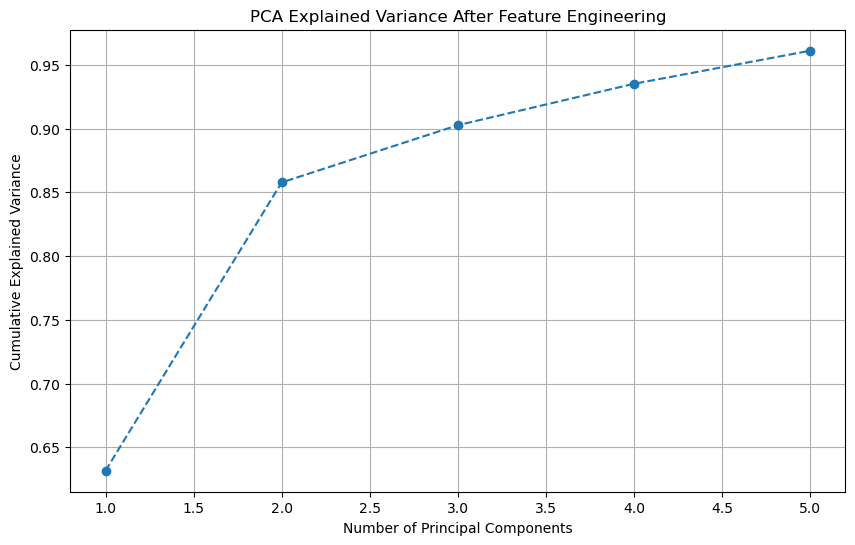

Explained Variance Ratio for Each Component: [0.63169263 0.22604476 0.04488313 0.03246675 0.02594813]
Number of Components Selected: 5
PCA-Transformed Data:


,PC1,PC2,PC3,PC4,PC5
0,-0.799011,1.002617,-0.036950,0.309030,0.110653
1,0.624641,0.998959,-0.042462,0.044349,0.378435
2,-0.771784,0.728700,-0.071919,-0.198860,0.045158
3,0.639891,0.417538,-0.023930,0.232822,0.138379
4,0.672185,-0.332884,-0.010483,-0.055506,0.128648


In [6]:
# Applying PCA to reduce the number of features while retaining 95% variance
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(df_filtered[features_to_normalize])

# Analyzing explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Cumulative explained variance plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance After Feature Engineering')
plt.grid()
plt.show()

print(f"Explained Variance Ratio for Each Component: {explained_variance}")
print(f"Number of Components Selected: {pca.n_components_}")

# Saving the PCA-transformed data into a new DataFrame for clustering
pca_columns = [f"PC{i+1}" for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca_result, columns=pca_columns)

# Displaying the first few rows of the PCA-transformed data
print("PCA-Transformed Data:")
display(df_pca.head())

# Dimensionality Reduction: UMAP 

/home/cveerla/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/scratch/local/ipykernel_42674/120189585.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df_umap[:, 0], y=df_umap[:, 1], palette="tab10", s=10)


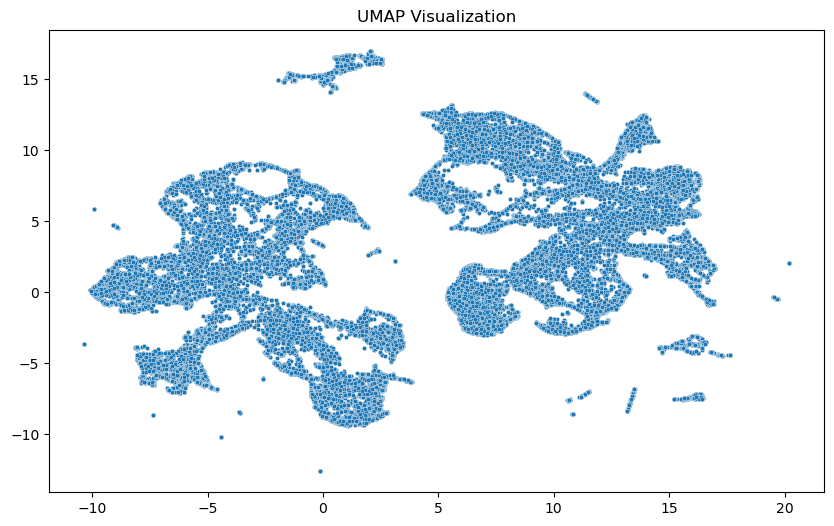

In [8]:
import umap.umap_ as umap
umap_model = umap.UMAP(n_components=2, random_state=42)
df_umap = umap_model.fit_transform(df_filtered[features_to_normalize])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_umap[:, 0], y=df_umap[:, 1], palette="tab10", s=10)
plt.title("UMAP Visualization")
plt.show()

# KMeans & GMM on UMAP

K-Means Silhouette Score: 0.4237928
GMM Silhouette Score: 0.40884128
K-Means Davies-Bouldin Index: 0.8726557436228467
GMM Davies-Bouldin Index: 0.9233330529360252


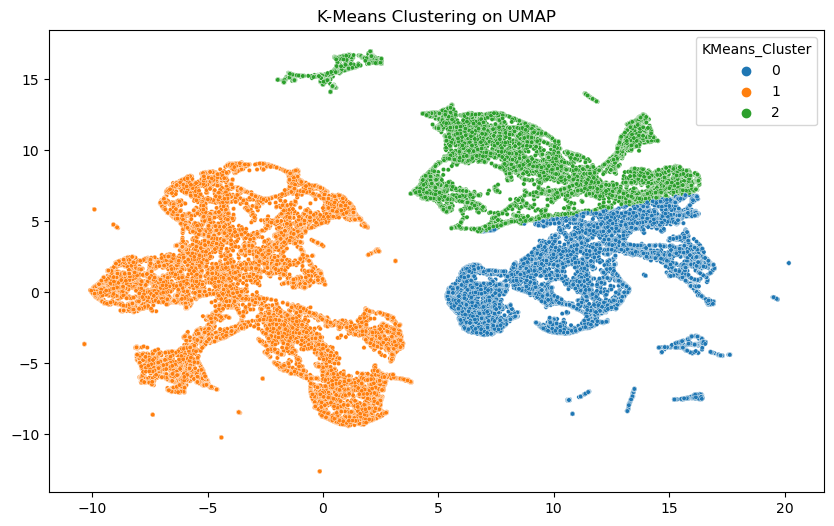

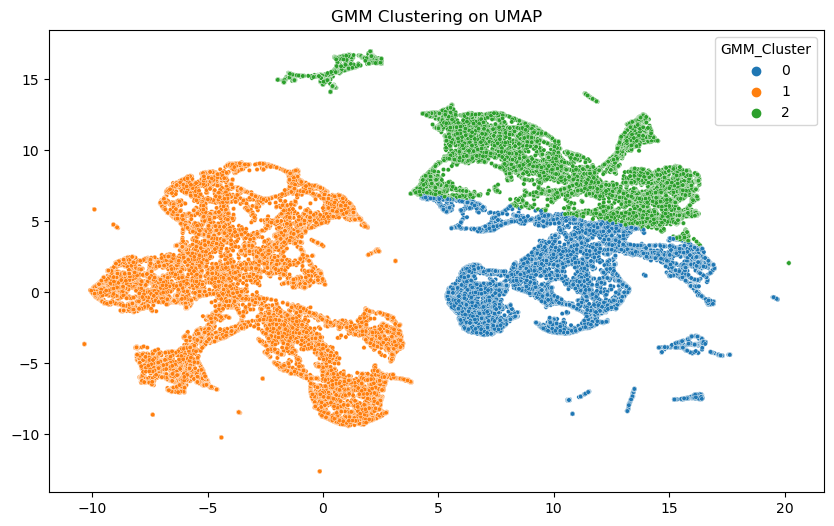

Cluster Summary (K-Means):


/scratch/local/ipykernel_42674/3018300347.py:42: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_summary = df_filtered.groupby('KMeans_Cluster').mean()


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,demand_score,distance_to_landmark,booking_probability,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_dominance,GMM_Cluster
KMeans_Cluster,,,,,,,,,,,,,,,,,,
0,1.847177e+07,6.355935e+07,0.619943,0.512467,0.023435,0.008668,0.025074,1.075626,18.339858,0.326197,0.003502,0.115391,0.088075,1.000000,0.0,0.000000,0.053190,0.292257
1,1.946893e+07,7.247514e+07,0.555130,0.567329,0.008978,0.003505,0.038335,1.444378,3.227717,0.304668,0.008327,0.219271,0.194950,0.000000,1.0,0.000000,0.006833,1.000000
2,1.881782e+07,6.351945e+07,0.482203,0.560168,0.017434,0.002970,0.047640,1.556516,1.834656,0.297852,0.009791,0.244640,0.208297,0.908841,0.0,0.091159,0.002560,1.802279


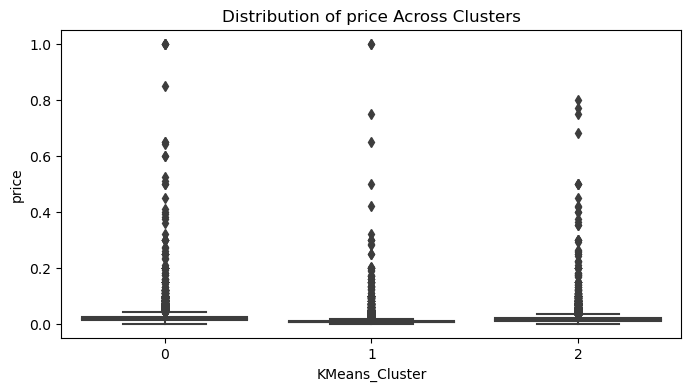

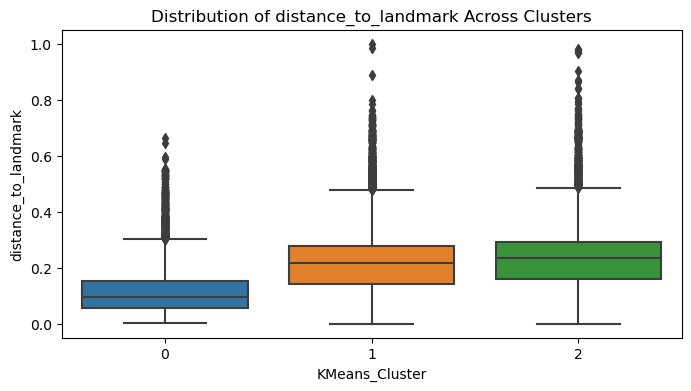

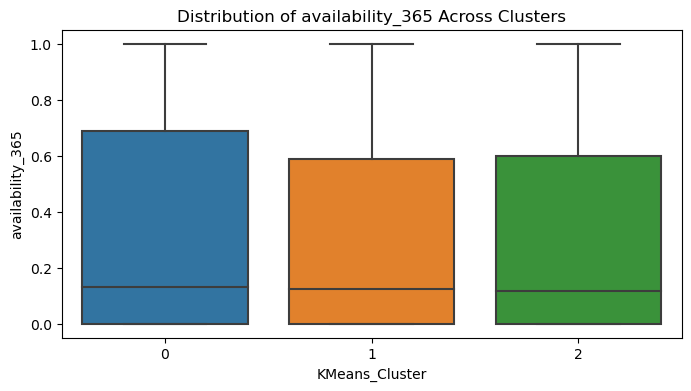

In [11]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt


# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_filtered['KMeans_Cluster'] = kmeans.fit_predict(df_umap)

# Gaussian Mixture Model (GMM) Clustering
gmm = GaussianMixture(n_components=3, random_state=42)
df_filtered['GMM_Cluster'] = gmm.fit_predict(df_umap)

# Evaluate Clustering

# Silhouette Scores
print("K-Means Silhouette Score:", silhouette_score(df_umap, df_filtered['KMeans_Cluster']))
print("GMM Silhouette Score:", silhouette_score(df_umap, df_filtered['GMM_Cluster']))

# Davies-Bouldin Scores
print("K-Means Davies-Bouldin Index:", davies_bouldin_score(df_umap, df_filtered['KMeans_Cluster']))
print("GMM Davies-Bouldin Index:", davies_bouldin_score(df_umap, df_filtered['GMM_Cluster']))

# Visualize Clustering Results

# K-Means Clustering Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_umap[:, 0], y=df_umap[:, 1], hue=df_filtered['KMeans_Cluster'], palette='tab10', s=10)
plt.title("K-Means Clustering on UMAP")
plt.show()

# GMM Clustering Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_umap[:, 0], y=df_umap[:, 1], hue=df_filtered['GMM_Cluster'], palette='tab10', s=10)
plt.title("GMM Clustering on UMAP")
plt.show()

# Analyze Clusters

cluster_summary = df_filtered.groupby('KMeans_Cluster').mean()
print("Cluster Summary (K-Means):")
display(cluster_summary)

# Visualize cluster-wise distribution of key features
for feature in ['price', 'distance_to_landmark', 'availability_365']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='KMeans_Cluster', y=feature, data=df_filtered)
    plt.title(f"Distribution of {feature} Across Clusters")
    plt.show()

# Clustering on PCA reduced data
+ KMeans, BIRCH, Ward Agglomerative, Ensemble of KMeans, BIRCH and Ward
## Elbow method - Optimal k

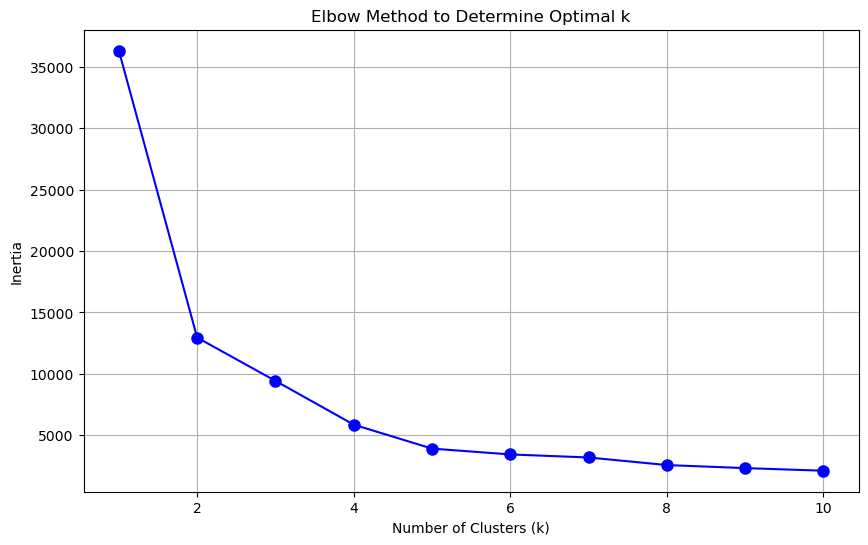

In [18]:
# Elbow Method to Determine Optimal K
inertia = []
K = range(1, 11)  # Test for k=1 to k=10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)  # Use PCA-transformed data
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.grid()
plt.show()

In [13]:
# Evaluate Clustering Metrics for each k
for k in [3, 4]:
    print(f"\nTesting with k = {k}")

    # K-Means Clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(df_pca)
    silhouette_kmeans = silhouette_score(df_pca, kmeans_labels)
    davies_bouldin_kmeans = davies_bouldin_score(df_pca, kmeans_labels)
    calinski_harabasz_kmeans = calinski_harabasz_score(df_pca, kmeans_labels)
    print(f"K-Means Silhouette Score (k={k}): {silhouette_kmeans:.3f}")
    print(f"K-Means Davies-Bouldin Index (k={k}): {davies_bouldin_kmeans:.3f}")
    print(f"K-Means Calinski-Harabasz Index (k={k}): {calinski_harabasz_kmeans:.3f}")

    # BIRCH Clustering
    birch = Birch(n_clusters=k, threshold=0.01)
    birch_labels = birch.fit_predict(df_pca)
    silhouette_birch = silhouette_score(df_pca, birch_labels)
    davies_bouldin_birch = davies_bouldin_score(df_pca, birch_labels)
    calinski_harabasz_birch = calinski_harabasz_score(df_pca, birch_labels)
    print(f"BIRCH Silhouette Score (k={k}): {silhouette_birch:.3f}")
    print(f"BIRCH Davies-Bouldin Index (k={k}): {davies_bouldin_birch:.3f}")
    print(f"BIRCH Calinski-Harabasz Index (k={k}): {calinski_harabasz_birch:.3f}")

    # Agglomerative Clustering
    agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agglo_labels = agglo.fit_predict(df_pca)
    silhouette_agglo = silhouette_score(df_pca, agglo_labels)
    davies_bouldin_agglo = davies_bouldin_score(df_pca, agglo_labels)
    calinski_harabasz_agglo = calinski_harabasz_score(df_pca, agglo_labels)
    print(f"Agglomerative Silhouette Score (k={k}): {silhouette_agglo:.3f}")
    print(f"Agglomerative Davies-Bouldin Index (k={k}): {davies_bouldin_agglo:.3f}")
    print(f"Agglomerative Calinski-Harabasz Index (k={k}): {calinski_harabasz_agglo:.3f}")


Testing with k = 3
K-Means Silhouette Score (k=3): 0.576
K-Means Davies-Bouldin Index (k=3): 0.752
K-Means Calinski-Harabasz Index (k=3): 69703.777
BIRCH Silhouette Score (k=3): 0.649
BIRCH Davies-Bouldin Index (k=3): 0.669
BIRCH Calinski-Harabasz Index (k=3): 58416.577
Agglomerative Silhouette Score (k=3): 0.577
Agglomerative Davies-Bouldin Index (k=3): 0.650
Agglomerative Calinski-Harabasz Index (k=3): 67373.642

Testing with k = 4
K-Means Silhouette Score (k=4): 0.575
K-Means Davies-Bouldin Index (k=4): 0.740
K-Means Calinski-Harabasz Index (k=4): 84587.937
BIRCH Silhouette Score (k=4): 0.614
BIRCH Davies-Bouldin Index (k=4): 0.665
BIRCH Calinski-Harabasz Index (k=4): 64517.641
Agglomerative Silhouette Score (k=4): 0.555
Agglomerative Davies-Bouldin Index (k=4): 0.854
Agglomerative Calinski-Harabasz Index (k=4): 75058.582


In [14]:
# Clustering Results
k = 3  # Chosen number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(df_pca)

birch = Birch(n_clusters=k, threshold=0.01)
birch_labels = birch.fit_predict(df_pca)

agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
agglo_labels = agglo.fit_predict(df_pca)

# Combining Cluster Labels
ensemble_df = pd.DataFrame({
    'KMeans': kmeans_labels,
    'BIRCH': birch_labels,
    'Agglomerative': agglo_labels
})

# Meta-Clustering (Consensus)
meta_clustering_model = KMeans(n_clusters=k, random_state=42)
ensemble_labels = meta_clustering_model.fit_predict(ensemble_df)

# Evaluating the Ensemble Clustering
silhouette_ensemble = silhouette_score(df_pca, ensemble_labels)
davies_bouldin_ensemble = davies_bouldin_score(df_pca, ensemble_labels)
calinski_harabasz_ensemble = calinski_harabasz_score(df_pca, ensemble_labels)

print(f"Ensemble Silhouette Score: {silhouette_ensemble:.3f}")
print(f"Ensemble Davies-Bouldin Index: {davies_bouldin_ensemble:.3f}")
print(f"Ensemble Calinski-Harabasz Index: {calinski_harabasz_ensemble:.3f}")


Ensemble Silhouette Score: 0.576
Ensemble Davies-Bouldin Index: 0.752
Ensemble Calinski-Harabasz Index: 69703.777


/scratch/local/ipykernel_42674/903106708.py:11: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(


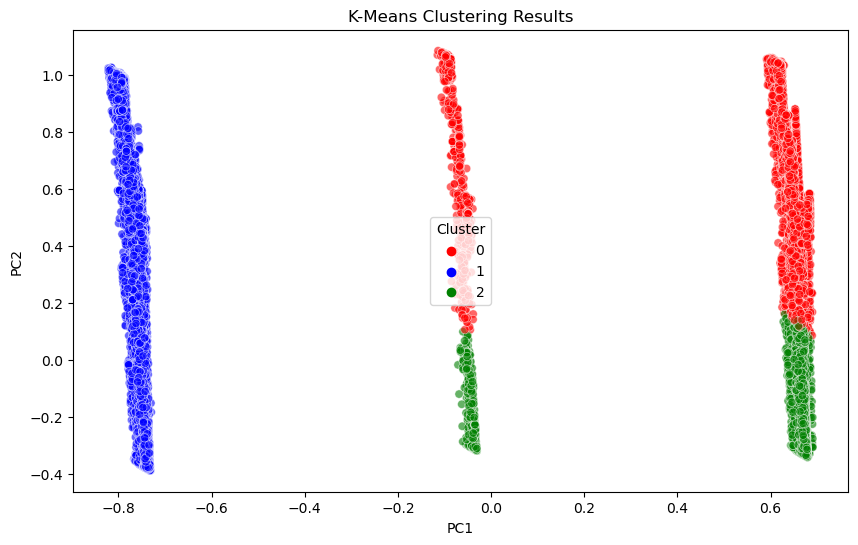

/scratch/local/ipykernel_42674/903106708.py:11: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(


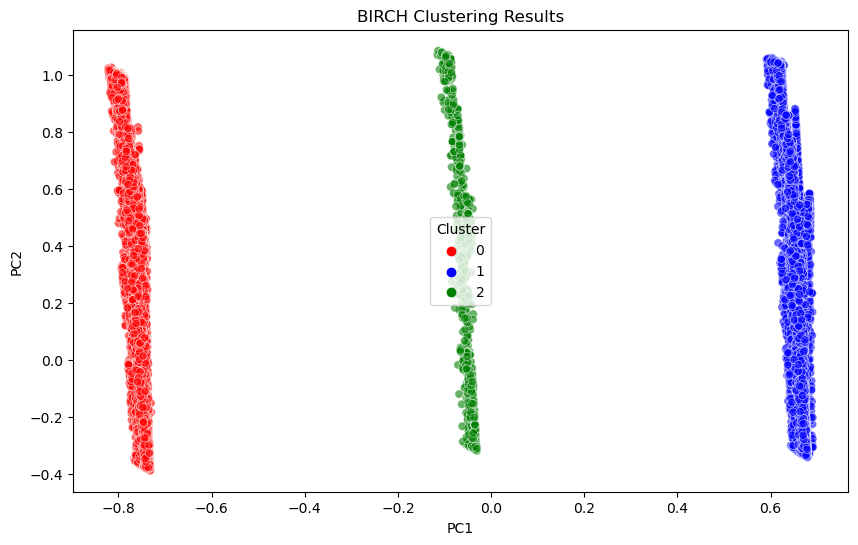

/scratch/local/ipykernel_42674/903106708.py:11: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(


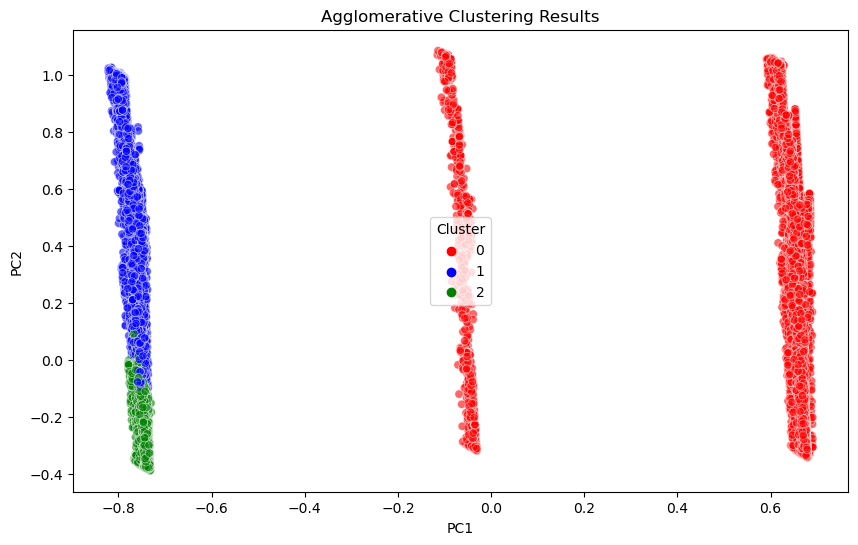

/scratch/local/ipykernel_42674/903106708.py:11: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(


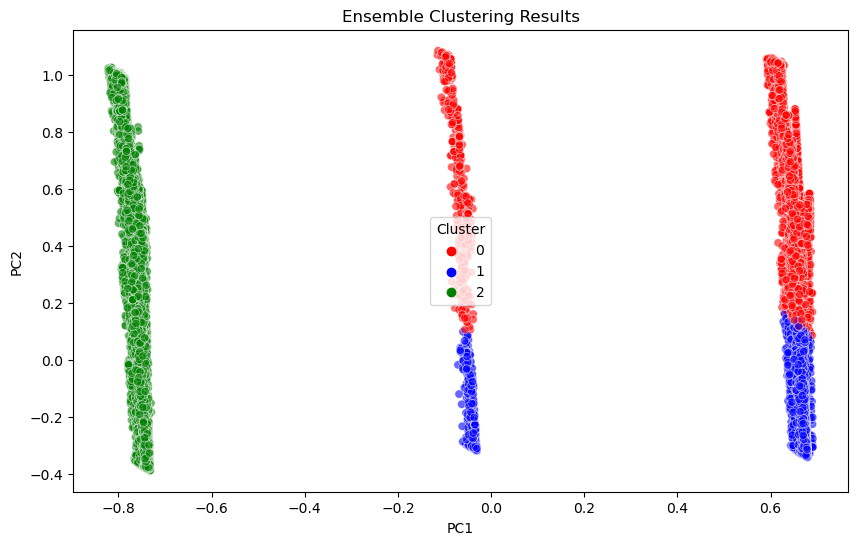

In [15]:
# Scatter Plots for All Methods
methods = {
    "K-Means": kmeans_labels,
    "BIRCH": birch_labels,
    "Agglomerative": agglo_labels,
    "Ensemble": ensemble_labels
}

for method_name, labels in methods.items():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df_pca['PC1'], y=df_pca['PC2'], hue=labels,
        palette=['red', 'blue', 'green', 'yellow'], alpha=0.6
    )
    plt.title(f'{method_name} Clustering Results')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Cluster', loc='best')
    plt.show()

# Cluster Analysis

Cluster Characteristics Summary:


,price,demand_score,distance_to_landmark,booking_probability,host_dominance
Cluster,,,,,
0,0.023797,0.010607,0.183320,0.354530,0.074123
1,0.008978,0.008327,0.219271,0.194950,0.006833
2,0.018826,0.004320,0.174063,0.033669,0.004718


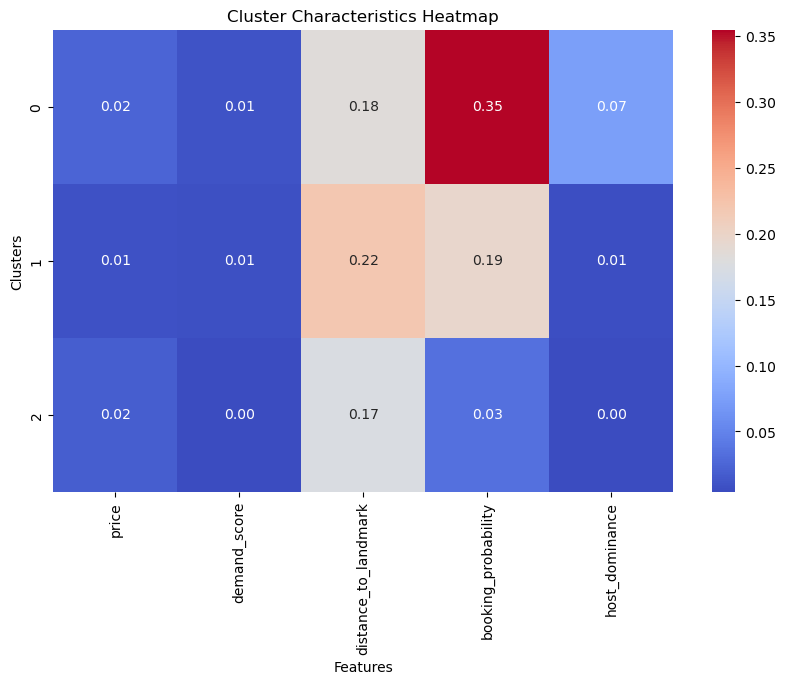

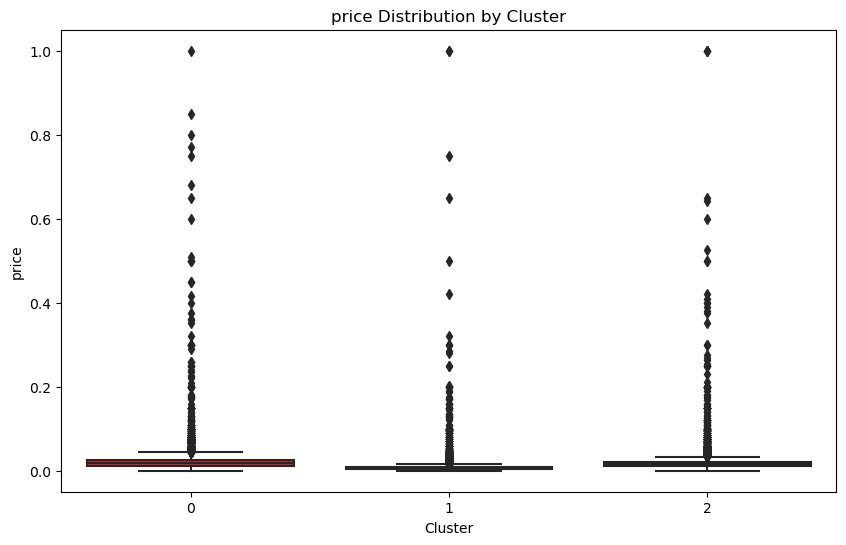

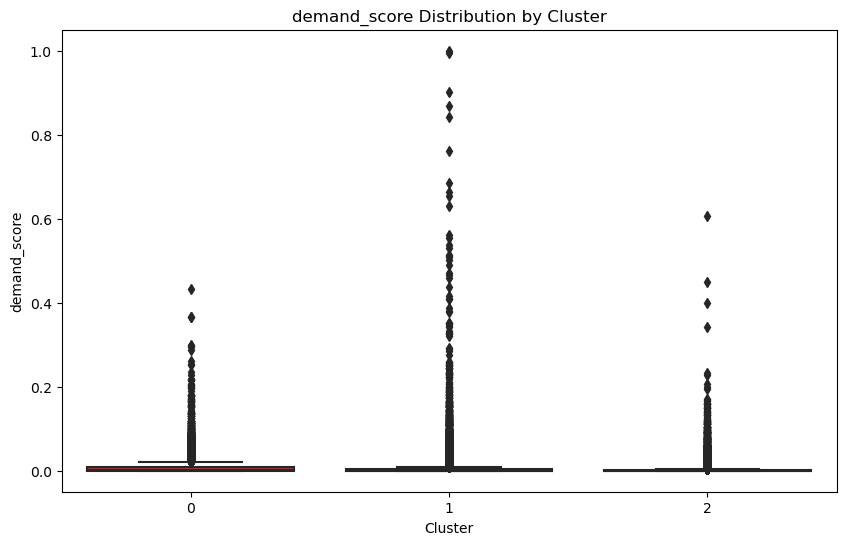

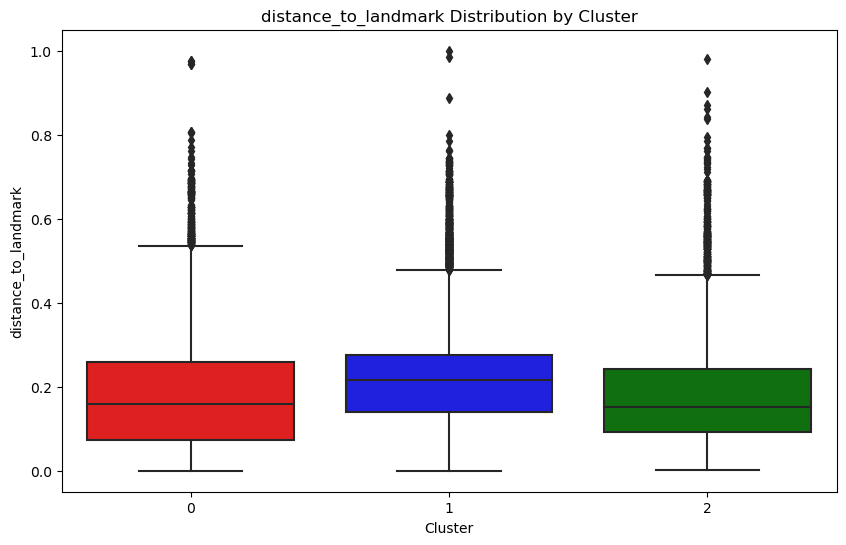

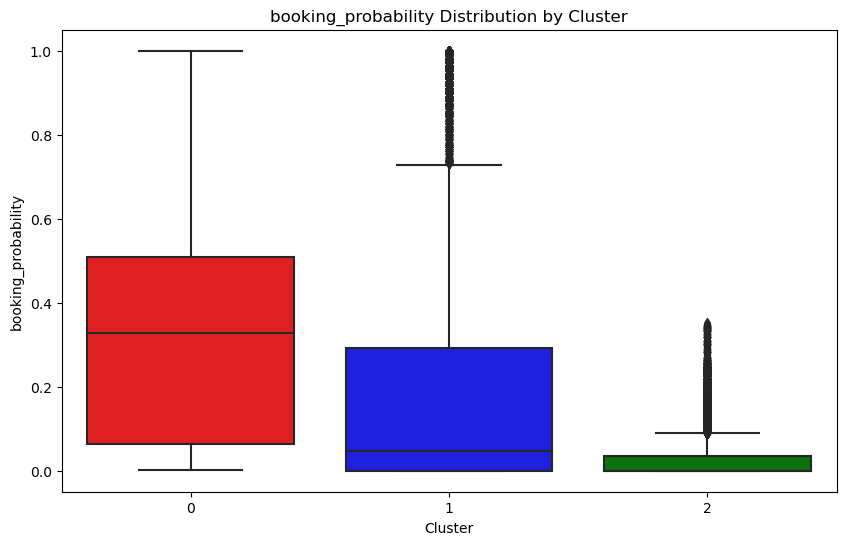

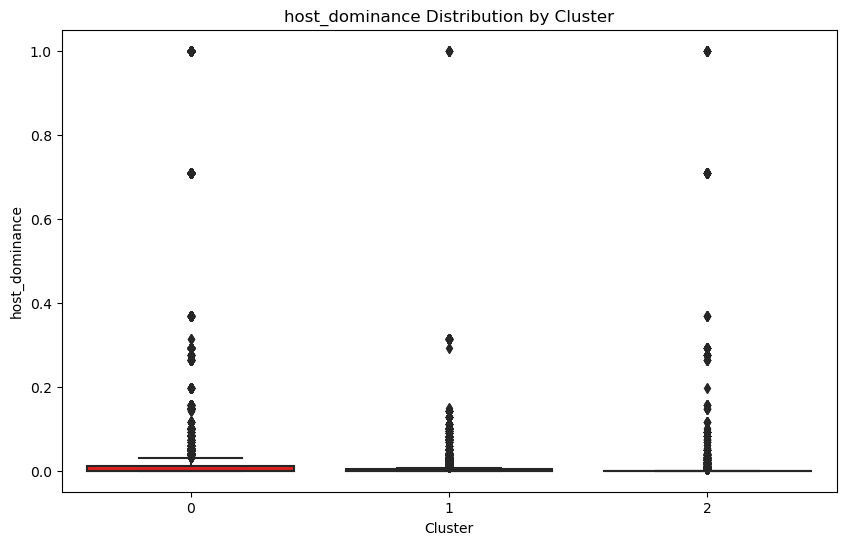

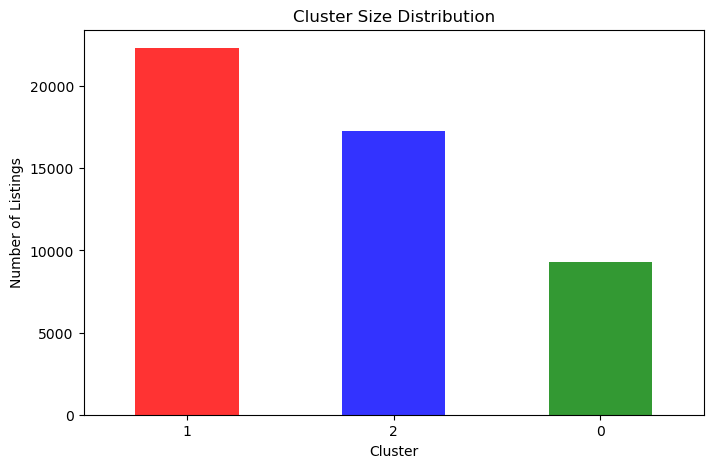

Clustered dataset with cluster labels saved successfully!


In [16]:
# Analyzing Cluster Characteristics and Visualizing Insights

# Adding cluster labels to the dataset
df_filtered['Cluster'] = kmeans_labels  

# Selecting key features to analyze
key_features = ['price', 'demand_score', 'distance_to_landmark', 'booking_probability', 'host_dominance']

# Calculating the cluster-wise mean for key features
cluster_summary = df_filtered.groupby('Cluster')[key_features].mean()

# Displaying the cluster summary table
print("Cluster Characteristics Summary:")
display(cluster_summary)

# Heatmap for cluster characteristics
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Cluster Characteristics Heatmap')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

# Visualizing the feature distributions across clusters using boxplots
for feature in key_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=df_filtered, palette=['red', 'blue', 'green', 'yellow'])
    plt.title(f'{feature} Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()

# Analyzing the cluster sizes
cluster_sizes = df_filtered['Cluster'].value_counts()

# Plotting the cluster size distribution
plt.figure(figsize=(8, 5))
cluster_sizes.plot(kind='bar', color=['red', 'blue', 'green', 'yellow'], alpha=0.8)
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Listings')
plt.xticks(rotation=0)
plt.show()

# Saving the cluster results to a CSV for further use
df_filtered.to_csv('clustered_airbnb_data.csv', index=False)
print("Clustered dataset with cluster labels saved successfully!")


### Insights and Analysis of Clusters (k = 3)

#### Cluster Characteristics Summary
| **Cluster** | **Price** | **Demand Score** | **Distance to Landmark** | **Booking Probability** | **Host Dominance** |
|-------------|-----------|------------------|---------------------------|--------------------------|---------------------|
| **0**       | 0.023797  | 0.010607         | 0.183320                  | 0.354530                | 0.074123            |
| **1**       | 0.008978  | 0.008327         | 0.219271                  | 0.194950                | 0.006833            |
| **2**       | 0.018826  | 0.004320         | 0.174063                  | 0.033669                | 0.004718            |

#### Key Insights
1. **Cluster 0**:
   - **Price**: Higher compared to other clusters, indicating listings with relatively premium pricing.
   - **Demand Score**: Moderate demand based on reviews and engagement.
   - **Distance to Landmark**: Relatively close to the landmark (e.g., Times Square), suggesting central location listings.
   - **Booking Probability**: High, indicating these listings are frequently booked and likely cater to short-term stays.
   - **Host Dominance**: Higher than other clusters, showing these listings may belong to experienced hosts managing multiple properties.

2. **Cluster 1**:
   - **Price**: Lowest among all clusters, indicating budget-friendly listings.
   - **Demand Score**: Slightly lower compared to Cluster 0, reflecting moderate customer engagement.
   - **Distance to Landmark**: Furthest from the landmark compared to other clusters, indicating listings in less central locations.
   - **Booking Probability**: Moderate, suggesting steady bookings but not as high as Cluster 0.
   - **Host Dominance**: Relatively low, likely indicating individual or small-scale hosts.

3. **Cluster 2**:
   - **Price**: Mid-range, falling between Clusters 0 and 1.
   - **Demand Score**: Lowest among the clusters, reflecting lower engagement and reviews.
   - **Distance to Landmark**: Closest to the landmark, suggesting highly central or premium-location listings.
   - **Booking Probability**: Very low, possibly due to longer minimum stays or other constraints.
   - **Host Dominance**: Lowest, suggesting these are single listings or managed by inexperienced hosts.

#### Visualization Analysis
1. **Heatmap**:
   - Highlights distinct differences in characteristics across clusters.
   - **Cluster 0** shows dominance in booking probability and moderate pricing.
   - **Cluster 1** focuses on budget pricing but with steady booking probability.
   - **Cluster 2** demonstrates proximity to landmarks but has lower booking activity.

2. **Boxplots**:
   - Show the distributions of features like price, demand score, booking probability, and distance to the landmark.
   - **Cluster 0** has a wider range in `booking probability`, reflecting higher variability in booking preferences.
   - **Cluster 1** shows consistency in budget pricing.
   - **Cluster 2** exhibits tighter clustering around landmark proximity.

3. **Cluster Size Distribution**:
   - Cluster 1 is the largest, showing most listings fall into the budget-friendly category.
   - Cluster 2, while small, likely represents exclusive or niche listings near landmarks.
   - Cluster 0 indicates listings that balance premium pricing with central locations.

#### Business Implications
1. **Cluster 0**:
   - Target premium customers seeking centrally located properties.
   - Potential for dynamic pricing to maximize revenue given higher booking probability.

2. **Cluster 1**:
   - Focus on budget travelers.
   - Opportunity to highlight unique features to stand out in competitive pricing.

3. **Cluster 2**:
   - Premium properties near landmarks require tailored marketing for exclusive audiences.
   - Address factors reducing booking probability (e.g., minimum stay policies).

# Predictive Modeling

Feature Matrix (X) Shape: (48895, 13)
Target (y) Shape: (48895,)
Evaluating Random Forest with 10-fold cross-validation...
Random Forest - Mean CV Accuracy: 0.9990, Std: 0.0006
Evaluating Logistic Regression with 10-fold cross-validation...
Logistic Regression - Mean CV Accuracy: 0.9991, Std: 0.0003
Evaluating Support Vector Machine (SVM) with 10-fold cross-validation...
Support Vector Machine (SVM) - Mean CV Accuracy: 0.9990, Std: 0.0005

Training and evaluating Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1855
           1       1.00      1.00      1.00      4465
           2       1.00      1.00      1.00      3459

    accuracy                           1.00      9779
   macro avg       1.00      1.00      1.00      9779
weighted avg       1.00      1.00      1.00      9779



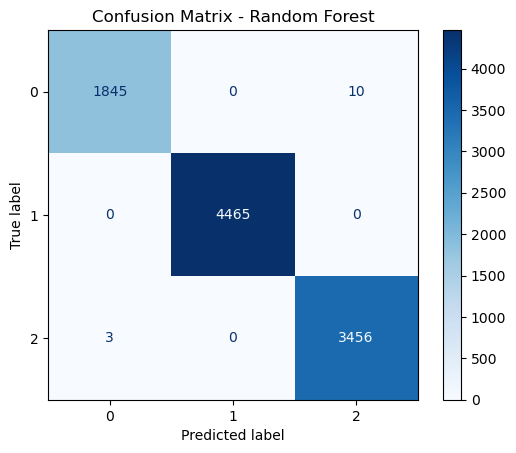


Training and evaluating Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1855
           1       1.00      1.00      1.00      4465
           2       1.00      1.00      1.00      3459

    accuracy                           1.00      9779
   macro avg       1.00      1.00      1.00      9779
weighted avg       1.00      1.00      1.00      9779



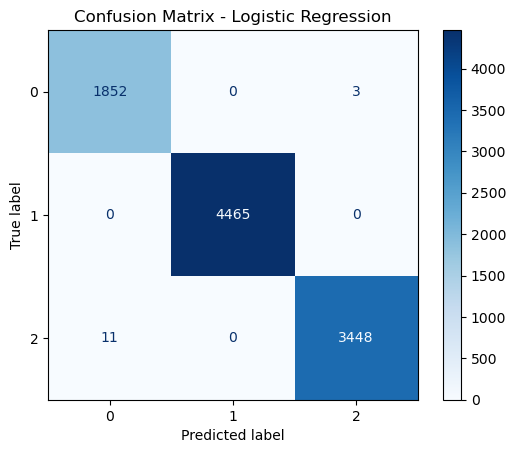


Training and evaluating Support Vector Machine (SVM)...
Classification Report for Support Vector Machine (SVM):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1855
           1       1.00      1.00      1.00      4465
           2       1.00      1.00      1.00      3459

    accuracy                           1.00      9779
   macro avg       1.00      1.00      1.00      9779
weighted avg       1.00      1.00      1.00      9779



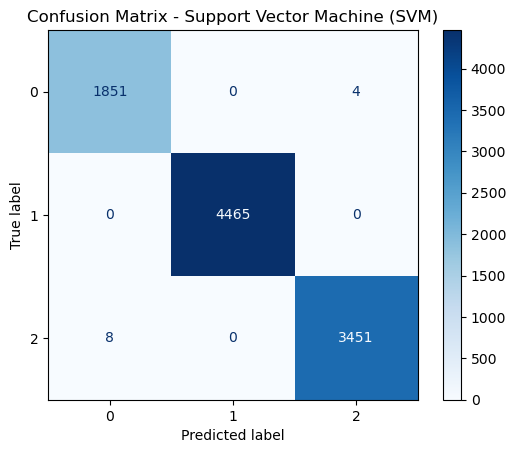


Cross-Validation Results Summary:
Random Forest: Mean Accuracy = 0.9990, Std = 0.0006
Logistic Regression: Mean Accuracy = 0.9991, Std = 0.0003
Support Vector Machine (SVM): Mean Accuracy = 0.9990, Std = 0.0005


In [17]:
# Defining X (features) and y (target)
X = df_filtered[features_to_normalize]  # Use all normalized features
# X = df_filtered[['price', 'distance_to_landmark', 'demand_score', 'booking_probability']]

if 'Cluster_KMeans' not in df_filtered.columns:
    df_filtered['Cluster_KMeans'] = kmeans_labels  # Assign labels if not already in the dataframe

# Set y as the cluster labels
y = df_filtered['Cluster_KMeans']
# Verify shapes of X and y
print("Feature Matrix (X) Shape:", X.shape)
print("Target (y) Shape:", y.shape)

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Splitting data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Defining models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Support Vector Machine (SVM)": SVC(random_state=42)
}

# Number of splits for cross-validation
n_splits = 10
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Evaluate models using cross-validation
cv_results = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name} with {n_splits}-fold cross-validation...")
    cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    cv_results[model_name] = {
        "Mean CV Accuracy": cv_scores.mean(),
        "Std CV Accuracy": cv_scores.std()
    }
    print(f"{model_name} - Mean CV Accuracy: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")

# Training and evaluating models
for model_name, model in models.items():
    print(f"\nTraining and evaluating {model_name}...")
    # Training the model
    model.fit(X_train, y_train)
    
    # Predicting on test data
    y_pred = model.predict(X_test)
    
    # Evaluating model
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Displaying the cross-validation results
print("\nCross-Validation Results Summary:")
for model_name, metrics in cv_results.items():
    print(f"{model_name}: Mean Accuracy = {metrics['Mean CV Accuracy']:.4f}, Std = {metrics['Std CV Accuracy']:.4f}")